#Question2

2 Data source: Any standard/non-standards pair of images
I. Implement the Eight point algorithm for the image rectification display the two images before and after rectification.
II. Implement the Harris Corner Detection Algorithm plot the corners back to images and display.

#Eight Point Algorithm

In [ ]:
pip install opencv-python

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
image1 = cv2.imread('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/I1.png', 0)  # Load the first grayscale image
image2 = cv2.imread('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/I2.png', 0)  # Load the second grayscale image
print("Image 1 shape:", image1.shape)
print("Image 2 shape:", image2.shape)

Image 1 shape: (444, 274)
Image 2 shape: (444, 274)


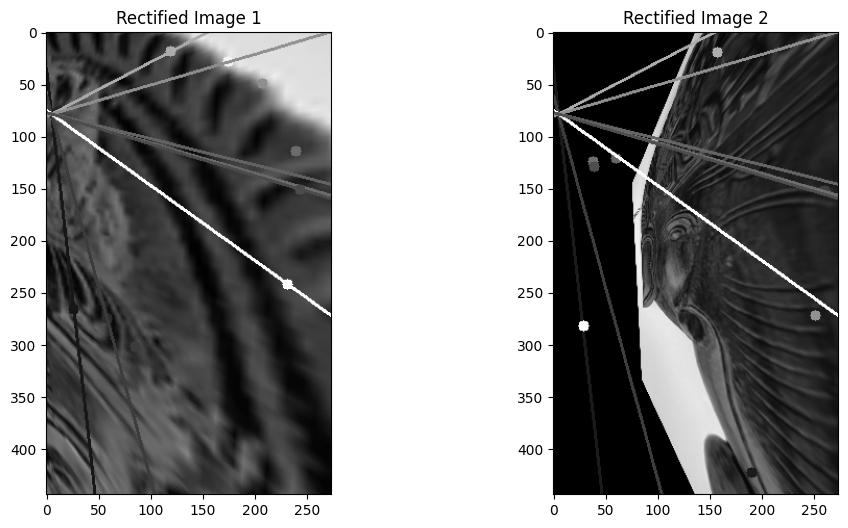

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Load images in grayscale
image1 = cv2.imread('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/I1.png', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/drive/MyDrive/EE511_Assignments/D22180_Nandani_Sharma_Assignment2/I2.png', cv2.IMREAD_GRAYSCALE)

# Create SIFT object
sift = cv2.SIFT_create()

# Find keypoints and descriptors
keypoints1, descriptors1 = sift.detectAndCompute(image1, None)
keypoints2, descriptors2 = sift.detectAndCompute(image2, None)

# FLANN parameters for feature matching
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(descriptors1, descriptors2, k=2)

# Ratio test to find good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

# Draw matches
matchesMask = [[1, 0] for _ in range(len(good_matches))]
matched_image = cv2.drawMatchesKnn(image1, keypoints1, image2, keypoints2, [good_matches], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Find corresponding points
points1 = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
points2 = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Compute fundamental matrix
fundamental_matrix, _ = cv2.findFundamentalMat(points1, points2, cv2.FM_LMEDS)

# Compute epipolar lines
lines1 = cv2.computeCorrespondEpilines(points2, 2, fundamental_matrix)
lines1 = lines1.reshape(-1, 3)
lines2 = cv2.computeCorrespondEpilines(points1, 1, fundamental_matrix)
lines2 = lines2.reshape(-1, 3)

# Compute rectification transformation matrices
h1, w1 = image1.shape
h2, w2 = image2.shape
_, H1, H2 = cv2.stereoRectifyUncalibrated(points1, points2, fundamental_matrix, imgSize=(w1, h1))

# Rectify images
rectified_image1 = cv2.warpPerspective(image1, H1, (w1, h1))
rectified_image2 = cv2.warpPerspective(image2, H2, (w2, h2))

# Draw epipolar lines and points on rectified images
for r, pt1, pt2 in zip(lines1, points1, points2):
    color = tuple(np.random.randint(0, 255, 3).tolist())
    x0, y0 = map(int, [0, -r[2]/r[1]])
    x1, y1 = map(int, [w1, -(r[2]+r[0]*w1)/r[1]])
    rectified_image1 = cv2.line(rectified_image1, (x0, y0), (x1, y1), color, 2)

    # Convert pt1 to tuple of integers
    pt1 = tuple(map(int, pt1[0]))
    rectified_image1 = cv2.circle(rectified_image1, pt1, 5, color, -1)

    x0, y0 = map(int, [0, -r[2]/r[1]])
    x1, y1 = map(int, [w2, -(r[2]+r[0]*w2)/r[1]])
    rectified_image2 = cv2.line(rectified_image2, (x0, y0), (x1, y1), color, 2)

    # Convert pt2 to tuple of integers
    pt2 = tuple(map(int, pt2[0]))
    rectified_image2 = cv2.circle(rectified_image2, pt2, 5, color, -1)

# Display images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(rectified_image1, cmap='gray')
plt.title('Rectified Image 1')

plt.subplot(1, 2, 2)
plt.imshow(rectified_image2, cmap='gray')
plt.title('Rectified Image 2')

plt.show()


#Harris Corner Detection

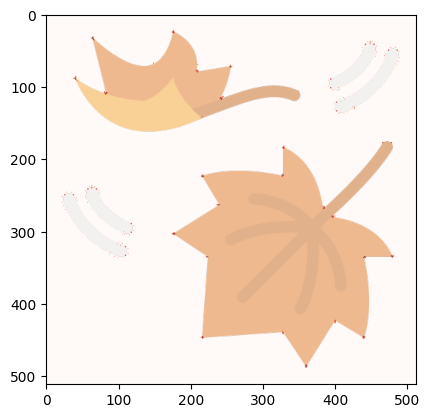

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_gradients(image):
    kernel_x = np.array([[-1, 0, 1]])
    kernel_y = np.array([[-1], [0], [1]])

    Ix = np.zeros_like(image, dtype=np.float32)
    Iy = np.zeros_like(image, dtype=np.float32)

    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            Ix[i, j] = np.sum(image[i - 1:i + 2, j - 1:j + 2] * kernel_x)
            Iy[i, j] = np.sum(image[i - 1:i + 2, j - 1:j + 2] * kernel_y)

    return Ix, Iy

def harris_corner_detection(image, window_size=3, k=0.04, threshold=0.01):
    Ix, Iy = compute_gradients(image)

    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix * Iy

    offset = window_size // 2
    height, width = image.shape
    corners = np.zeros((height, width))

    for i in range(offset, height - offset):
        for j in range(offset, width - offset):
            Sxx = np.sum(Ixx[i - offset:i + offset + 1, j - offset:j + offset + 1])
            Syy = np.sum(Iyy[i - offset:i + offset + 1, j - offset:j + offset + 1])
            Sxy = np.sum(Ixy[i - offset:i + offset + 1, j - offset:j + offset + 1])

            # Calculate corner response function R
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            R = det - k * (trace**2)

            # Apply threshold and non-maximum suppression
            if R > threshold:
                corners[i, j] = R

    return corners

# Load the input image in grayscale
image = plt.imread('/content/drive/MyDrive/E511_Assignments/D22180_Nandani_Sharma_Assignment2/hc1.png')
gray_image = np.mean(image, axis=-1)  # Convert to grayscale if the image is in color

# Perform Harris Corner Detection
corners = harris_corner_detection(gray_image)

# Threshold the corner response values to get corner points
thresholded_corners = (corners > 0.01 * corners.max()) * 255

# Plot corners back on the original image
plt.imshow(image, cmap='gray')
plt.imshow(thresholded_corners, alpha=0.5, cmap='Reds')
plt.show()


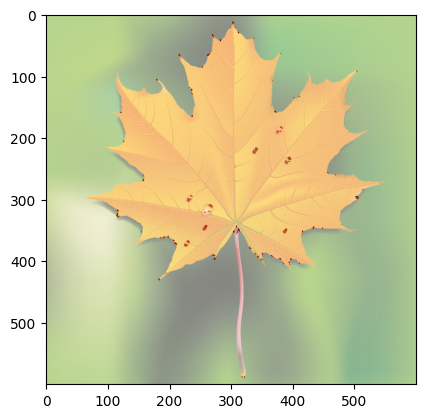

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def compute_gradients(image):
    kernel_x = np.array([[-1, 0, 1]])
    kernel_y = np.array([[-1], [0], [1]])

    Ix = np.zeros_like(image, dtype=np.float32)
    Iy = np.zeros_like(image, dtype=np.float32)

    for i in range(1, image.shape[0] - 1):
        for j in range(1, image.shape[1] - 1):
            Ix[i, j] = np.sum(image[i - 1:i + 2, j - 1:j + 2] * kernel_x)
            Iy[i, j] = np.sum(image[i - 1:i + 2, j - 1:j + 2] * kernel_y)

    return Ix, Iy

def harris_corner_detection(image, window_size=3, k=0.04, threshold=0.01):
    Ix, Iy = compute_gradients(image)

    Ixx = Ix**2
    Iyy = Iy**2
    Ixy = Ix * Iy

    offset = window_size // 2
    height, width = image.shape
    corners = np.zeros((height, width))

    for i in range(offset, height - offset):
        for j in range(offset, width - offset):
            Sxx = np.sum(Ixx[i - offset:i + offset + 1, j - offset:j + offset + 1])
            Syy = np.sum(Iyy[i - offset:i + offset + 1, j - offset:j + offset + 1])
            Sxy = np.sum(Ixy[i - offset:i + offset + 1, j - offset:j + offset + 1])

            # Calculate corner response function R
            det = (Sxx * Syy) - (Sxy**2)
            trace = Sxx + Syy
            R = det - k * (trace**2)

            # Apply threshold and non-maximum suppression
            if R > threshold:
                corners[i, j] = R

    return corners

# Load the input image in grayscale
image = plt.imread('/content/drive/MyDrive/E511_Assignments/D22180_Nandani_Sharma_Assignment2/HC.jpg')
gray_image = np.mean(image, axis=-1)  # Convert to grayscale if the image is in color

# Perform Harris Corner Detection
corners = harris_corner_detection(gray_image)

# Threshold the corner response values to get corner points
thresholded_corners = (corners > 0.01 * corners.max()) * 255

# Plot corners back on the original image
plt.imshow(image, cmap='gray')
plt.imshow(thresholded_corners, alpha=0.5, cmap='Reds')
plt.show()
